# Data Science approach for analysis of apartments in Nur-Sultan (Astana), Kazakhstan

This notebook performs data analysis of apartments in Nur-Sultan (Kazakhstan) and price prediction based on input information about apartments. Data is obtained through web-scraping www.krisha.kz website pages and later analyzed. The current real estate market in Nur-Sultan is investigated and the fundamentals of the housing market is presented. 

Regression models are carried out and tested based on the cleaned data from the web-scraping. The regression models are used to predict the prices of apartments. The results are evaluated and direction of future works are stated.

The results were highly successfull that the model can be used for producing predictions of apartment prices by real-state agencies or apartment owners.

## 1. Web scraping apartment list in Nur-Sultan 

Web scraping was carried out via BeautifulSoup library in python which is parses HTML and XML pages allowing users to fetch contents from URL and parse some certain parts of them. 

**Warning:** It took 12 minutes to scrap the whole list of apartment ads in Nur-Sultan. In order to not to wait for web scraping, it is better to run from chapter '#2.


*1.1. Getting the number of apartments found and number of pages found by search.*

Ad website krisha.kz can show only 20 ads in one page. Hence, it is needed to know the number of ads and number of pages found by search in order to get all the information by web scraping. 

For every page found, it is needed to do web scraping.

In [1]:
# importing relevant libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

page = requests.get("https://krisha.kz/prodazha/kvartiry/nur-sultan/?das[checked]=1&das[who]=1&page=1")
soup = BeautifulSoup(page.content, 'html.parser')

parsed_list_of_ads = soup.find('section', attrs={'class': 'a-search-container main-cols-container'})

# The function below gets the total number of ads
def get_total_number_ads(parsed_list):
    text = parsed_list.find(class_="a-search-subtitle search-results-nb").get_text()
    res = [int(i) for i in text.split() if i.isdigit()] 
    total_number = res[0]*1000+res[1]
    return total_number

total_ad_number = get_total_number_ads(parsed_list_of_ads)
number_of_pages = int(total_ad_number/20) + 1

print("The total number of apartments found by search is " + str(total_ad_number))
print("The total number of pages found by search is " + str(number_of_pages))

The total number of apartments found by search is 19428
The total number of pages found by search is 972


*1.2. Function tokenize gets the list of words from the web scraped text.*

The function below returns list of words (strings) from the web scraped text. It splits string by splitter characters.

In [2]:
# The function tokenize is needed to get the list of words from web scraping 

def tokenize(content):
    splitter = [" ", "\n", ",", ")", "\"", "–", "-", "/", "\xa0"]
    result_list = []
    current_word = ""
    for x in content:
        if x in splitter:
            if current_word != "":
                result_list.append(current_word)
            current_word = ""
        else:
            current_word += x
            
    return result_list

*1.3. The function gets the whole text from the specific page.*

The function below returns the web scrapped text from specific page.

In [3]:
# getting the whole text from the specific page
def get_soup_spec_page(page_number):
    URL = 'https://krisha.kz/prodazha/kvartiry/nur-sultan/?das[checked]=1&das[who]=1&page=' + str(page_number)
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    full_list = soup.find('section', attrs={'class': 'a-list a-search-list a-list-with-favs'})
    return full_list

*1.4. The function below gets the needed data from web scrapped text and saves in Pandas dataframe.*

The function below gets the information about apartments such as number of rooms, area, storey number, total storey number, price, district, complex name, year, condition. Then it will save all the information in pandas dataframe. That will be our main dataset.

**Warning: Running next cell will take much time (around 10 minutes).**

In [6]:
def get_df_list(full_list):
    df_apartments = pd.DataFrame(columns=['number_of_rooms', 'area', 'storey_number', 
                                          'total_storey_number', 'price', 'district', 
                                          'complex_name', 'year', 'condition'])
    adv_elems = full_list.find_all(True, {'class':['a-card__descr']})
    for elem in adv_elems:
        data_id = elem.find('a', class_='a-card__title').get_text()
        number_of_bedrooms_with_area_draft = elem.find('a', class_='a-card__title').get_text()
        number_of_bedrooms_with_area = tokenize(number_of_bedrooms_with_area_draft)
        number_of_rooms = int(number_of_bedrooms_with_area[0])
        area = float(number_of_bedrooms_with_area[3])
        
        if len(number_of_bedrooms_with_area) > 5:
            storey_number = number_of_bedrooms_with_area[5]
            if len(number_of_bedrooms_with_area) < 7:
                total_storey_number = np.nan
            else:
                total_storey_number = number_of_bedrooms_with_area[6]
        else:
            storey_number = np.nan
            total_storey_number = np.nan
        
        
        price_draft = tokenize(elem.find('div', class_='a-card__price').get_text())
        
        if price_draft[0].isnumeric() and price_draft[1].isnumeric() and price_draft[2].isnumeric():
            price = int(price_draft[0]+price_draft[1]+price_draft[2])
        elif price_draft[1].isnumeric() and price_draft[2].isnumeric() and price_draft[3].isnumeric():
            price = int(price_draft[1]+price_draft[2]+price_draft[3])
        else:
            price = np.nan
            
        district_draft = elem.find('div', class_='a-card__subtitle').get_text()
        district_draft = tokenize(district_draft)
        district = np.nan
        if len(district_draft)>1 and district_draft[1] == 'р' and district_draft[2] == 'н':
            district = district_draft[0]
        complex_name_draft = elem.find('div', class_ = 'a-card__text-preview').get_text()
        complex_name_draft = tokenize(complex_name_draft)
        year = np.nan
        for i in range(11):
            if len(complex_name_draft[i]) == 4 and complex_name_draft[i].isdigit():
                year = int(complex_name_draft[i])
                break
        apartment_type_list = ['кирпичный', 'монолитный', 'панельный']
        complex_name = np.nan
        if complex_name_draft[0] == 'жил.':
            complex_name = complex_name_draft[2]
            if complex_name_draft[3].isnumeric() == False and complex_name_draft[3] not in apartment_type_list:
                complex_name += ' '
                complex_name += complex_name_draft[3]
        condition = np.nan
        if 'состояние:' in complex_name_draft:
            index = complex_name_draft.index('состояние:')
            condition = complex_name_draft[index+1]
        df_apartments.loc[len(df_apartments.index)] = [number_of_rooms, area, storey_number, total_storey_number, price, district, complex_name, year, condition]
    return df_apartments

df = pd.DataFrame(columns=['number_of_rooms', 'area', 'storey_number', 'total_storey_number', 'price', 'district', 'complex_name', 'year', 'condition'])
for i in range(number_of_pages):
    df = df.append(get_df_list(get_soup_spec_page(i+1)), ignore_index = True)

df

number_of_rooms    area storey_number total_storey_number     price  \
0                   2   50.79           NaN                 NaN  13205400   
1                   2   58.02           NaN                 NaN  17115900   
2                   1   36.12           NaN                 NaN  10474800   
3                   3  110.00             5                  18  39500000   
4                   3   55.90             3                   9  24500000   
...               ...     ...           ...                 ...       ...   
18995               1   40.00             5                   9  14000000   
18996               3   76.00             9                  10  28000000   
18997               4  137.00             8                  12  67000000   
18998               3   72.00             4                   6  22000000   
18999               1   43.78             9                  10  13500000   

       district complex_name  year   condition  
0           NaN     Budapest  2021         NaN  
1         Есиль         Эмир  2021         NaN  
2         Есиль    Inju city  2021         NaN  
3      Сарыарка       Бурлин  2011  евроремонт  
4         Есиль     Absolute  2018  евроремонт  
...         ...          ...   ...         ...  
18995     Есиль      Керемет  2015     хорошее  
18996    Алматы     Сарайшик  2015  евроремонт  
18997     Есиль     LandMark  2021         NaN  
18998       NaN    Эксклюзив  2017     хорошее  
18999       NaN    Эксклюзив  2017  евроремонт  

[19000 rows x 9 columns]

In [7]:
# Saving the dataframe in csv format
df.to_csv('krisha_analysis.csv') 

## 2. Data visualization

If you do not want to wait for web scraping, please start from here by downloading the dataframe from the saved csv file.
In this chapter, we will try to visulize data, find correlations between columns and find clearly noticed facts from the dataset.

### 2.1. Importing libraries, csv file and getting details about the file
*2.1.1. Importing libraries and downloading csv file.*

First, we will import necessary libraries and csv file.

In [311]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('krisha_analysis.csv', index_col = 0)

*2.1.2. Getting column dataframe information.*

We have some columns in float data type and other columns in object type. Dataset has some columns with nan values whereas some columns do not have any nan values.

In [312]:
print('Column data types:')
print(df.dtypes)
print('\n\nNumber of nan values:')
df.isna().sum()

Column data types:
number_of_rooms        float64
area                   float64
storey_number          float64
total_storey_number    float64
price                  float64
district                object
complex_name            object
year                   float64
condition               object
dtype: object


Number of nan values:


number_of_rooms           0
area                      0
storey_number           579
total_storey_number     827
price                     0
district               2975
complex_name           6835
year                      9
condition              2816
dtype: int64

We see that the following columns have no nan values: number_of_rooms, area, price. 

### 2.2. Plotting graphs; analysis of numerical columns

Some graphs are duplicated because I have created two types of graphs: one is interactive (plotly library) and second one is conventional (matplotlib). Interactive graphs cannot be seen in html format of the notebook and can be open by jupyter only. If you open this notebook in html format, you can look at matplotlib conventional type of graphs.

*2.2.1. Plotting graph: price vs area.*

Let's start with the affect of living area to the price.
In Nur-Sultan, when people buy new apartments they ask for the price per area of the apartments from the construction company. This means that these two data are linearly more or less dependent based on other factors. 

Text(0, 0.5, 'Price')

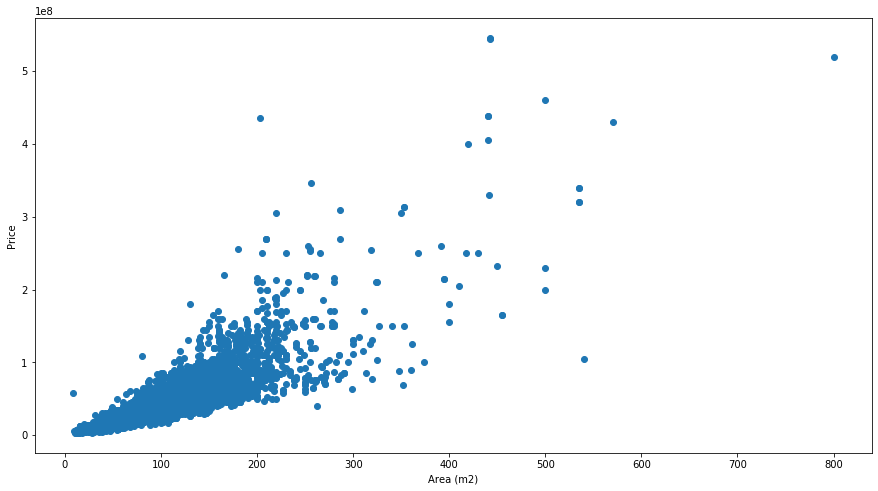

In [313]:
fig = px.scatter(df, x="area", y="price", hover_data=['number_of_rooms'])
fig.show()

plt.figure(figsize =(15, 8))
plt.scatter(df.area, df.price)
plt.xlabel("Area (m2)") 
plt.ylabel("Price") 

Scatter plots help us to see how data points are scattered and usually used for two variables. From the scatter graph above we can see that the more living area, the more data are concentrated toward particular price region. Also we can see a clear correlation between price and area that the data points seem to be linear direction. Hence, we can add a new data column which is price per area.

However, there are some irregularities that the more living area, the more spread apartment prices. Possible reasons might be that there are other factors that can affect to the price such as location, class type of the building, condition of apartments and etc.

*2.2.2. Adding new column: price_per_m2*
Average price per area in Nur-Sultan is shown below.

In [314]:
df['price_per_m2'] = df.price/df.area
print('Average price per m2 in Nur-Sultan is ' + str(df.price_per_m2.mean()))
df

Average price per m2 in Nur-Sultan is 383562.6321218058


number_of_rooms    area  storey_number  total_storey_number  \
0                  2.0   50.79            NaN                  NaN   
1                  2.0   58.02            NaN                  NaN   
2                  1.0   36.12            NaN                  NaN   
3                  3.0  110.00            5.0                 18.0   
4                  3.0   55.90            3.0                  9.0   
...                ...     ...            ...                  ...   
18995              1.0   40.00            5.0                  9.0   
18996              3.0   76.00            9.0                 10.0   
18997              4.0  137.00            8.0                 12.0   
18998              3.0   72.00            4.0                  6.0   
18999              1.0   43.78            9.0                 10.0   

            price  district complex_name    year   condition   price_per_m2  
0      13205400.0       NaN     Budapest  2021.0         NaN  260000.000000  
1      17115900.0     Есиль         Эмир  2021.0         NaN  295000.000000  
2      10474800.0     Есиль    Inju city  2021.0         NaN  290000.000000  
3      39500000.0  Сарыарка       Бурлин  2011.0  евроремонт  359090.909091  
4      24500000.0     Есиль     Absolute  2018.0  евроремонт  438282.647585  
...           ...       ...          ...     ...         ...            ...  
18995  14000000.0     Есиль      Керемет  2015.0     хорошее  350000.000000  
18996  28000000.0    Алматы     Сарайшик  2015.0  евроремонт  368421.052632  
18997  67000000.0     Есиль     LandMark  2021.0         NaN  489051.094891  
18998  22000000.0       NaN    Эксклюзив  2017.0     хорошее  305555.555556  
18999  13500000.0       NaN    Эксклюзив  2017.0  евроремонт  308359.981727  

[19000 rows x 10 columns]

*2.2.3. Plotting graph: number_of_rooms vs area*

Here, there is a correlation between number_of_rooms and area.

Text(0, 0.5, 'Number of rooms')

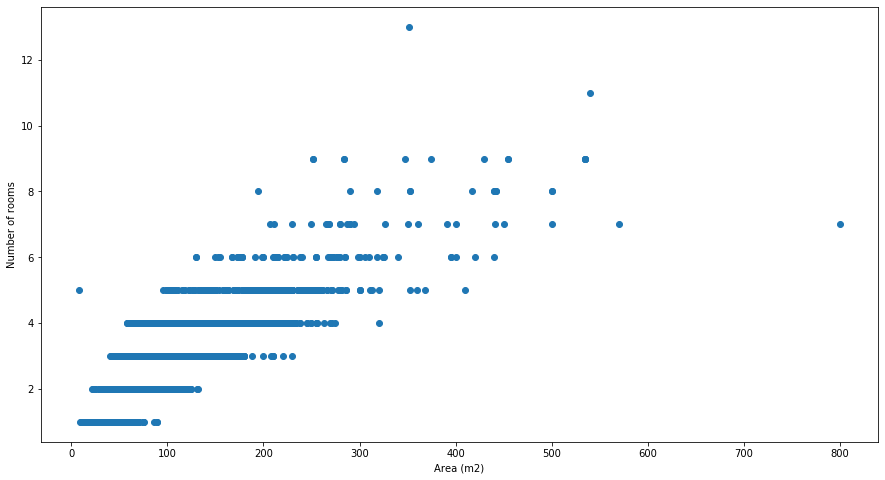

In [315]:
fig = px.scatter(df, x="area", y="number_of_rooms", hover_data=['number_of_rooms'])
fig.show()

plt.figure(figsize =(15, 8))
plt.scatter(df.area, df.number_of_rooms)
plt.xlabel("Area (m2)") 
plt.ylabel("Number of rooms") 

*2.2.4. Plotting graph: price_per_m2 vs area*.

I assumed that there might be a tendency when the area is getting higher the price_per_m2 gets lower. However, from the graph it is noticeable that there is no clear correlation between these two data columns.

Text(0, 0.5, 'Price per area (₸/m2)')

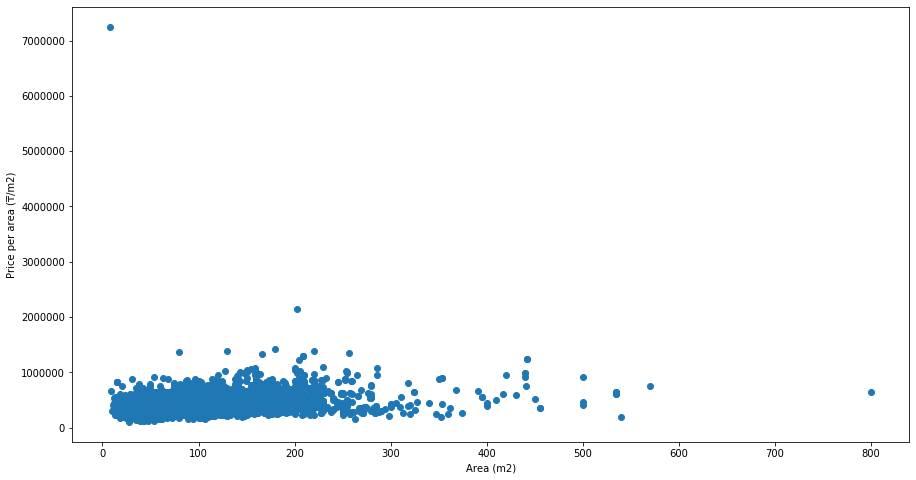

In [316]:
fig = px.scatter(df, x="area", y="price_per_m2", hover_data=['number_of_rooms'])
fig.show()

plt.figure(figsize =(15, 8))
plt.scatter(df.area, df.price_per_m2)
plt.xlabel("Area (m2)") 
plt.ylabel("Price per area (₸/m2)") 

*2.2.5. Number of rooms vs price graph.*

There is also correlation between number of rooms and price of the apartment.

Text(0, 0.5, 'Price (₸)')

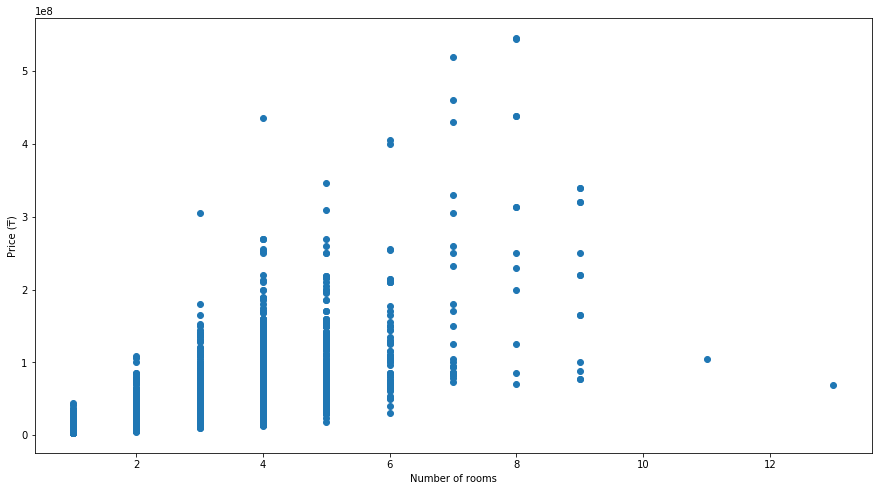

In [317]:
fig = px.scatter(df, x="number_of_rooms", y="price")
fig.show()

plt.figure(figsize =(15, 8))
plt.scatter(df.number_of_rooms, df.price)
plt.xlabel("Number of rooms") 
plt.ylabel("Price (₸)") 

In [318]:
df[df.price_per_m2 > 2000000]

number_of_rooms   area  storey_number  total_storey_number  \
11962              5.0    8.0            NaN                  NaN   
17126              4.0  203.0            6.0                  6.0   

             price district       complex_name    year   condition  \
11962   58000000.0      NaN                NaN  2006.0  евроремонт   
17126  435000000.0   Алматы  Миланский квартал  2014.0         NaN   

       price_per_m2  
11962  7.250000e+06  
17126  2.142857e+06

From the table above, we can notice the users when filling information about their apartmant for sale can put wrong information. An apartment with 5 rooms and 8 m2 area is impossible. 

### 2.3. Categorical column analysis
*2.3.1. Price per m2 by district graph.*

As people puts their ads on their own, they sometimes do not put some obvious information. For example, some people do not put district names when they put the name of residential complex. If a residential complex name is known, we can find its district.

Let's fill those district names where complex name is known and district name is unknown.

In [319]:
print('Number of ads where district was NaN value and residential complex was known:')
df[(df['district'].isnull()) & (df['complex_name'].notnull())].complex_name.unique().shape

Number of ads where district was NaN value and residential complex was known:


(377,)

Let's retrieve residential complexes names with district names based on the information in rows of dataset and save it in a dictionary. The dictionary's keys are residential complexes and values are district names.

In [320]:
district_resid_com_dict = {}
for index, row in df.iterrows():
    if pd.notnull(row.district) and pd.notnull(row.complex_name):
        if row.complex_name not in district_resid_com_dict:
            district_resid_com_dict[row.complex_name] = row.district
            
district_resid_com_dict

{'Эмир': 'Есиль',
 'Inju city': 'Есиль',
 'Бурлин': 'Сарыарка',
 'Absolute': 'Есиль',
 'Номад': 'Есиль',
 'Адина': 'Есиль',
 'Камал': 'Есиль',
 'Научный': 'Есиль',
 'Cosmic City': 'Есиль',
 'Коркем': 'Есиль',
 'ViewPark': 'Алматы',
 'Grand Opera': 'Есиль',
 'Baisanat': 'Есиль',
 'Boston Comfort': 'Есиль',
 'Paris': 'Есиль',
 'Алтын Шар': 'Есиль',
 'BI City': 'Есиль',
 'Максат': 'Сарыарка',
 'Sport City': 'Есиль',
 'Жагалау': 'Есиль',
 'Сенатор Park': 'Алматы',
 'Арай': 'Есиль',
 'Аулие Ата': 'Алматы',
 'МЖК Астана': 'Есиль',
 'Ак Орда': 'Есиль',
 'Хайвил Астана': 'Алматы',
 'Елорда Даму': 'Есиль',
 'Adal': 'Есиль',
 'Жансая': 'Есиль',
 'Manhattan': 'Есиль',
 'Премьера': 'Есиль',
 'Ак Шанырак': 'Алматы',
 'Бухар Жырау': 'Есиль',
 'София': 'Есиль',
 'Park Avenue': 'Есиль',
 'Dream City': 'Есиль',
 'Nova City': 'Есиль',
 'Brussels': 'Есиль',
 'Нур Канат': 'Есиль',
 'Nuraly apartments': 'Алматы',
 'Техникум': 'Есиль',
 'Athletic': 'Есиль',
 'Orynbor Towers': 'Есиль',
 'Ай Су': 'Алматы',
 '

Let's use the dictionary to fill district names where complex name is known and district name is unknown

In [321]:
for i in range(len(df)): 
    if pd.isnull(df.loc[i, 'district']) and pd.notnull(df.loc[i, 'complex_name']):
        if df.loc[i, 'complex_name'] in district_resid_com_dict:
            df.loc[i, 'district'] = district_resid_com_dict[df.loc[i, 'complex_name']]

print('Number of ads where district was NaN value and residential complex was known:')
df[(df['district'].isnull()) & (df['complex_name'].notnull())].complex_name.unique().shape

Number of ads where district was NaN value and residential complex was known:


(23,)

There are still ads left where the residential complex name is known and district is unknown. Hence, let's get the list of complex names with unknown districts.

In [322]:
df[(df['district'].isnull()) & (df['complex_name'].notnull())].complex_name.unique()

array(['Ансар', 'Жеруйык', 'R Club', 'Южный', 'По Янушкевича',
       'Китайская Стена', 'Абай', 'Изобилие', 'Жубанова', 'Байконыс',
       'Молодая семья', 'Астана Сити', 'Богенбай Батыр', 'Жаркын', 'Ален',
       'Замечательный', 'Сезам', 'Бараева', 'Солнечный', 'Оберег',
       'Минима+', 'Медео', 'Дарус'], dtype=object)

By googling those residential complexes, their district names were found. A new dictionary was created.

In [323]:
apartment_name_district_dict = {
    'Ансар': 'Есиль',
    'Жеруйык': 'Сарыарка',
    'R Club': 'Есиль', 
    'Южный': 'Сарыарка',
    'По Янушкевича': 'Сарыарка', 
    'Китайская Стена': 'Сарыарка', 
    'Абай': 'Сарыарка', 
    'Изобилие': 'Сарыарка', 
    'Жубанова': 'Сарыарка', 
    'Байконыс': 'Сарыарка', 
    'Молодая семья': 'Сарыарка',
    'Астана Сити': 'Сарыарка',
    'Богенбай Батыр': 'Сарыарка', 
    'Жаркын': 'Сарыарка', 
    'Ален': 'Сарыарка', 
    'Замечательный': 'Сарыарка',
    'Сезам': 'Сарыарка', 
    'Бараева': 'Сарыарка',
    'Солнечный': 'Сарыарка', 
    'Оберег': 'Алматы', 
    'Минима+': 'Алматы',
    'Медео': 'Сарыарка',
    'Дарус': 'Сарыарка'    
}

for i in range(len(df)) : 
    if pd.isnull(df.loc[i, 'district']) and pd.notnull(df.loc[i, 'complex_name']):
        if df.loc[i, 'complex_name'] in apartment_name_district_dict:
            df.loc[i, 'district'] = apartment_name_district_dict[df.loc[i, 'complex_name']]
df[(df['district'].isnull()) & (df['complex_name'].notnull())].complex_name.unique().shape

(0,)

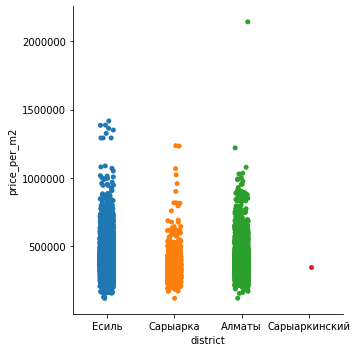

In [324]:
sns.catplot(x='district', y='price_per_m2', data=df)

We see only one ad that was located 'Сарыаркинский' which is the same with 'Сарыарка' name. One user wrote the long version of the district. Hence, it is needed to be renamed to 'Сарыарка'.

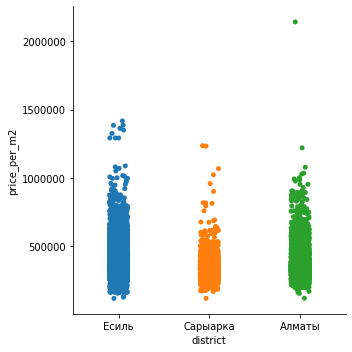

In [325]:
df["district"].replace({"Сарыаркинский": "Сарыарка"}, inplace=True)
sns.catplot(x='district', y='price_per_m2', data=df)

We can notice from the categorical graph that district 'Есиль' is the most expensive and has more ads than other two districts. The next most expensive district is 'Алматы'. The least expensive is the district 'Сарыарка'. However, there are still apartments in expensive districts which are cheaper than the least expensive district.

Let's check it by numbers.

In [326]:
df.groupby(['district'], as_index=False).price_per_m2.mean()

district   price_per_m2
0    Алматы  364667.554883
1     Есиль  425076.445688
2  Сарыарка  336266.889557

In [327]:
df.groupby(['district'], as_index=False).agg(count = pd.NamedAgg(column = 'price_per_m2', aggfunc = 'count'))

district  count
0    Алматы   6508
1     Есиль   7978
2  Сарыарка   3317

In [328]:
df.groupby(['district'], as_index=False).agg(min_price_per_m2 = pd.NamedAgg(column = 'price_per_m2', aggfunc = 'min'))

district  min_price_per_m2
0    Алматы     117021.276596
1     Есиль     115384.615385
2  Сарыарка     116279.069767

The abovementioned statements are proved by numbers. The highest mean price and the highest number of apartments are located in district 'Есиль', whereas the least ones are in district 'Сарыарка'.

We can state that the location of the apartment significantly affects on its price.

However, the cheapest apartment in district 'Есиль' (which is more expensive than other districts) is cheaper than the cheapest apartment in district 'Сарыарка'.

*2.3.2. Price per m2 by conditions.*

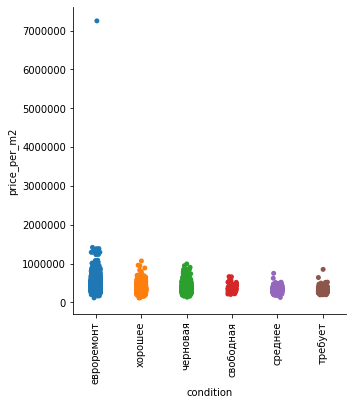

In [329]:
g = sns.catplot(x='condition', y='price_per_m2', data=df)
g.set_xticklabels(rotation=90)

There is a clear tendency, that if the condition is higher, the price is higher. Let's check by numbers.


In [330]:
df.groupby(['condition'], as_index=False).agg(mean_price_per_m2 = pd.NamedAgg(
    column = 'price_per_m2', aggfunc = 'mean')).sort_values(by=['mean_price_per_m2'], ascending=False)

condition  mean_price_per_m2
0  евроремонт      427188.977661
5    черновая      369968.448961
1   свободная      368572.157516
4     хорошее      355565.041270
2     среднее      326844.554993
3     требует      317126.621088

In [331]:
df.groupby(['condition'], as_index=False).agg(count = pd.NamedAgg(
    column = 'price_per_m2', aggfunc = 'count')).sort_values(by=['count'], ascending=False)

condition  count
0  евроремонт   7032
4     хорошее   5887
5    черновая   1829
2     среднее    990
3     требует    373
1   свободная     73

In [332]:
df.groupby(['condition'], as_index=False).agg(median_price_per_m2 = pd.NamedAgg(
    column = 'price_per_m2', aggfunc = 'median')).sort_values(by=['median_price_per_m2'], ascending=False)

condition  median_price_per_m2
0  евроремонт        402843.601896
5    черновая        364705.882353
1   свободная        363636.363636
4     хорошее        346153.846154
2     среднее        324324.324324
3     требует        315000.000000

*2.3.3. Graphs of prices by apartment names*

In [333]:
df_apartment_groupby = df.groupby(['complex_name'], as_index=False).agg(
    number_of_ads = pd.NamedAgg(column = 'price_per_m2', aggfunc = 'count'),
    district = pd.NamedAgg(column = 'district',aggfunc = 'first'),
    mean_price_per_m2 = pd.NamedAgg(column = 'price_per_m2', aggfunc = 'mean'),
    mean_area = pd.NamedAgg(column = 'area', aggfunc = 'mean')
)

In [334]:
df_apartment_groupby["district"].replace({np.nan: "Unknown"}, inplace=True)

Graph below shows top 50 residential complex with highest number of ads found for sale.

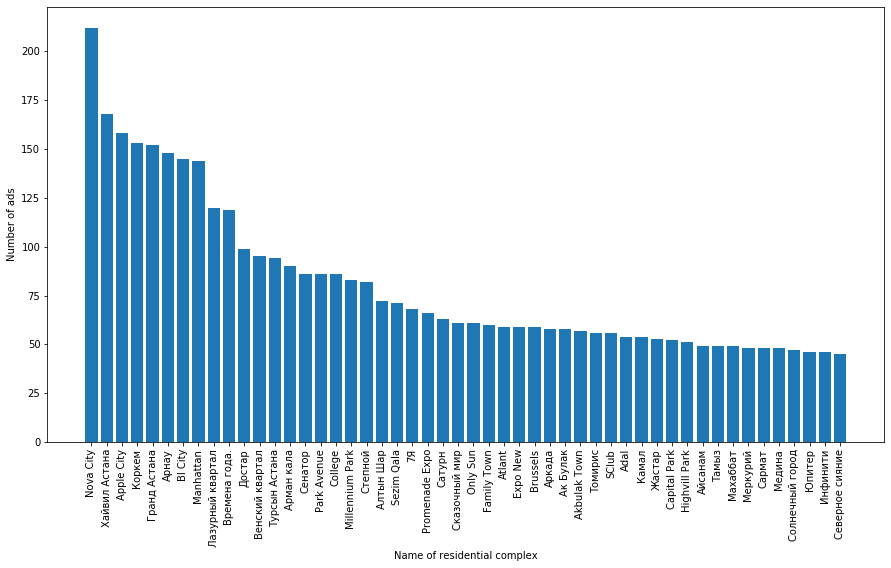

In [335]:
top_50_number_of_ads = df_apartment_groupby.sort_values(by=['number_of_ads'], ascending=False)[:50]
fig = px.bar(top_50_number_of_ads, x='complex_name', y='number_of_ads', hover_data = ['district', 'mean_price_per_m2', 'mean_area'])
fig.show()

plt.figure(figsize =(15, 8))
plt.bar(top_50_number_of_ads.complex_name, top_50_number_of_ads.number_of_ads) 
plt.xticks(rotation=90)
plt.ylabel("Number of ads") 
plt.xlabel("Name of residential complex") 
plt.show()

Top 50 most expensive residential complexes

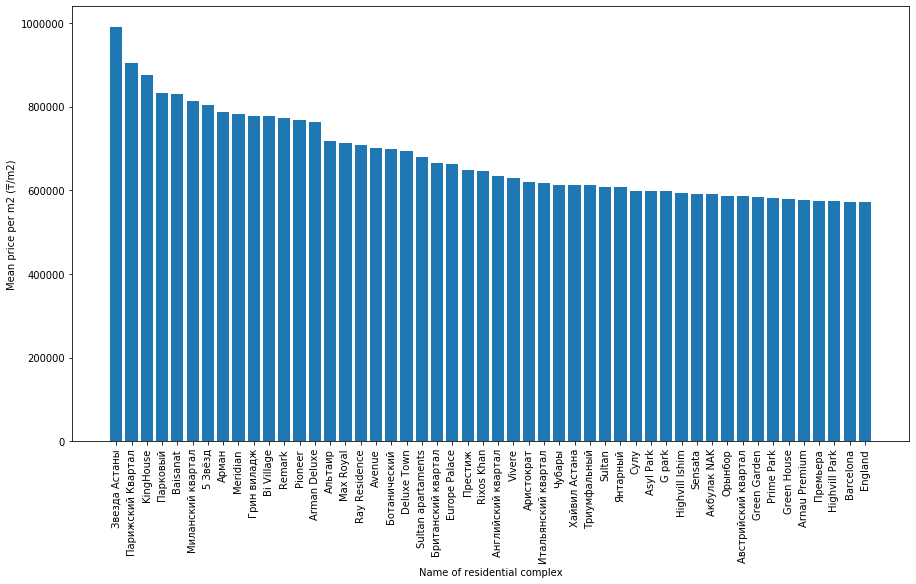

In [336]:
complexes_by_mean_price_per_area = df_apartment_groupby.sort_values(by=['mean_price_per_m2'], ascending=False)
fig = px.bar(complexes_by_mean_price_per_area[:50], x='complex_name', y='mean_price_per_m2', hover_data = [
    'district', 'number_of_ads', 'mean_area'])
fig.show()

plt.figure(figsize =(15, 8))
plt.bar(complexes_by_mean_price_per_area[:50].complex_name, complexes_by_mean_price_per_area[:50].mean_price_per_m2) 
plt.xticks(rotation=90)
plt.ylabel("Mean price per m2 (₸/m2)") 
plt.xlabel("Name of residential complex") 
plt.show()

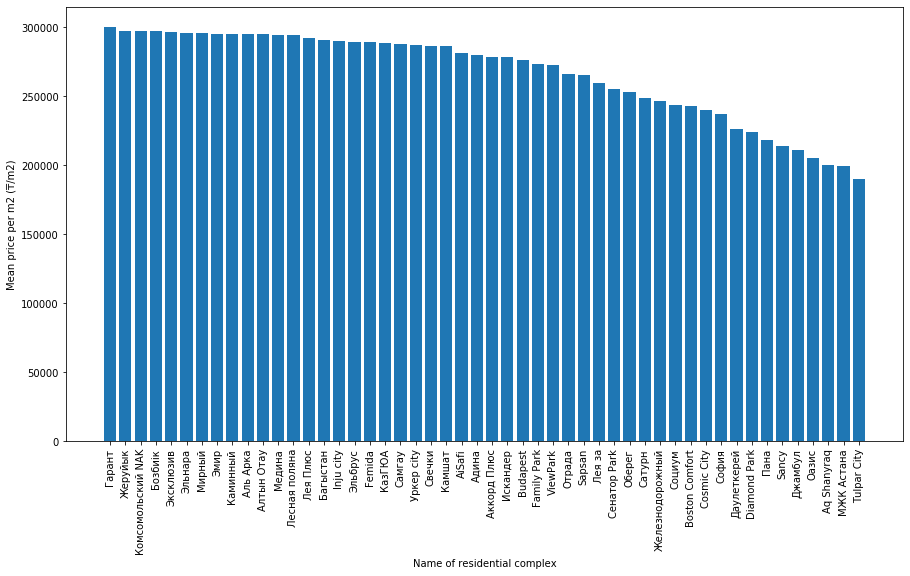

In [337]:
fig = px.bar(complexes_by_mean_price_per_area[-50:], x='complex_name', y='mean_price_per_m2', hover_data = [
    'district', 'number_of_ads', 'mean_area'])
fig.show()

plt.figure(figsize =(15, 8))
plt.bar(complexes_by_mean_price_per_area[-50:].complex_name, complexes_by_mean_price_per_area[-50:].mean_price_per_m2) 
plt.xticks(rotation=90)
plt.ylabel("Mean price per m2 (₸/m2)") 
plt.xlabel("Name of residential complex") 
plt.show()

Scatter graph below demonstrates residential complexes' mean price per m2 against mean area with the number of ads as the size of the dots on the graph. Colors distinguish the residential complexes' districts.

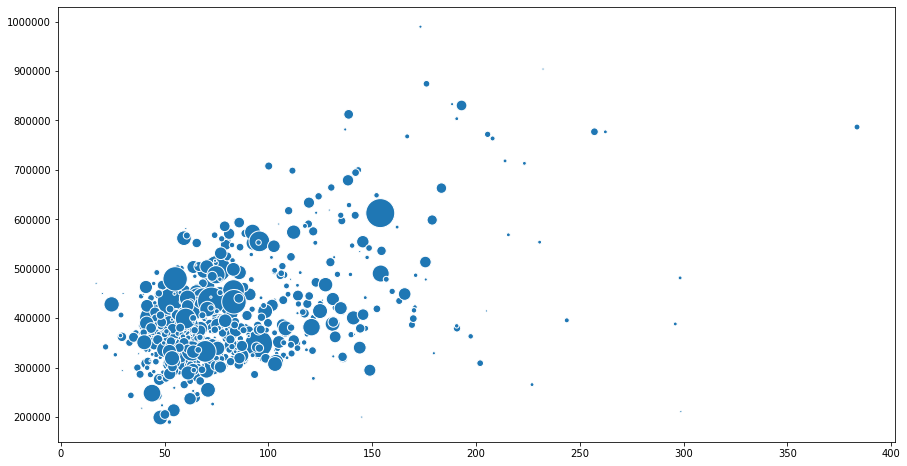

In [338]:
fig = px.scatter(df_apartment_groupby, x="mean_area", y="mean_price_per_m2", color="district", size='number_of_ads',
                 hover_data=['complex_name'])
fig.show()

plt.figure(figsize =(15, 8))
plt.scatter(df_apartment_groupby.mean_area, df_apartment_groupby.mean_price_per_m2, 
            s=df_apartment_groupby.number_of_ads*5.0, edgecolor = 'white') 

## 3. Model and prediction

In this chapter, we create a model that will predict price of apartments based on factors which are information about those apartments. The problem is regression type whose output will be price of apartments.

If we drop all nan valued rows we will lose almost half of the dataset. Therefore, those cells are needed to be filled by some values based on some assumptions.

In [339]:
print(df.shape)
print(df.dropna().shape)
df_model = df.copy()

(19000, 10)
(9893, 10)


### 3.1. Converting categorical or non-numerical columns into numerical data and filling nan valued cells with assumed numbers.

*3.1.1. Converting district names into numbers.*

Categorical numbers will be 0, 1 and 2 according to districts' average price per area.

In [340]:
district_prices = df_model.groupby(['district'], as_index=False).price_per_m2.mean().sort_values(by='price_per_m2')
district_prices.reset_index(drop=True)

district   price_per_m2
0  Сарыарка  336266.889557
1    Алматы  364667.554883
2     Есиль  425076.445688

In [341]:
df_model[(df_model['district'].isnull())].district.shape
# df_model[(df_model['complex_name'].isnull())].complex_name.shape
# df_model[(df_model['complex_name'].isnull())].complex_name.shape

(1197,)

In [342]:
for i in range(len(df_model)) : 
    if pd.isnull(df_model.loc[i, 'district']):
        if df_model.loc[i, 'price_per_m2'] > ((district_prices.loc[2, 'price_per_m2']+district_prices.loc[1, 'price_per_m2'])/2):
            df_model.loc[i, 'district'] = 2
        elif df_model.loc[i, 'price_per_m2'] <= ((district_prices.loc[2, 'price_per_m2']+district_prices.loc[
            1, 'price_per_m2'])/2) and df_model.loc[i, 'price_per_m2'] > ((
            district_prices.loc[1, 'price_per_m2']+district_prices.loc[0, 'price_per_m2'])/2):
            df_model.loc[i, 'district'] = 1
        elif df_model.loc[i, 'price_per_m2'] <= ((district_prices.loc[0, 'price_per_m2']+district_prices.loc[
            1, 'price_per_m2'])/2):
            df_model.loc[i, 'district'] = 0
            
    if df_model.loc[i, 'district'] == 'Сарыарка':
        df_model.loc[i, 'district'] = 0
    if df_model.loc[i, 'district'] == 'Алматы':
        df_model.loc[i, 'district'] = 1
    if df_model.loc[i, 'district'] == 'Есиль':
        df_model.loc[i, 'district'] = 2
    
df_model[(df_model['district'].isnull())].district.shape

(0,)

In [343]:
df_model.district.unique()

array([2, 0, 1], dtype=object)

*3.1.2. Creating a new column regarding storey number and converting it into numerical values.*

A new column is created which is the ratio of storey number and total storey number. 

In [344]:
df_model['storey_ratio'] = df_model.storey_number / df_model.total_storey_number
#df_model = df_model.drop(columns = ['storey_number', 'total_storey_number'])   

There are some rows in the dataset in which storey number is bigger than total storey number. In those cases, the user probably mixed up these two values. We need to change these two values.

In [345]:
df_model[df_model.storey_number > df_model.total_storey_number]

number_of_rooms    area  storey_number  total_storey_number  \
1351               1.0   31.50            5.0                  2.0   
1432               2.0   62.10           18.0                 15.0   
2229               2.0   65.00           17.0                  9.0   
3413               3.0  120.00            9.0                  3.0   
4492               3.0   56.00            6.0                  1.0   
6938               1.0   45.90            5.0                  1.0   
9533               4.0  140.00           43.0                 22.0   
10572              1.0   52.00            3.0                  1.0   
11365              3.0  100.00            5.0                  3.0   
11606              1.0   43.00            9.0                  1.0   
11996              2.0   60.00           14.0                  8.0   
12656              1.0   44.00            2.0                  1.0   
14357              1.0   30.00            7.0                  1.0   
16698              1.0   35.99            7.0                  6.0   
16818              1.0   40.40            7.0                  4.0   
17003              3.0   90.00            4.0                  3.0   
17717              2.0   50.00            9.0                  2.0   
17872              4.0  146.00            9.0                  4.0   
18713              2.0   64.00            4.0                  2.0   

            price district complex_name    year   condition   price_per_m2  \
1351   12000000.0        2          NaN  1967.0     хорошее  380952.380952   
1432   18100000.0        0       Эмират  2015.0     требует  291465.378422   
2229   26000000.0        1          NaN  2010.0  евроремонт  400000.000000   
3413   85000000.0        2          Уют  2010.0     хорошее  708333.333333   
4492   18000000.0        0          NaN  1978.0     хорошее  321428.571429   
6938   12000000.0        2          NaN  2014.0     хорошее  261437.908497   
9533   43000000.0        1          NaN  2013.0     требует  307142.857143   
10572  20000000.0        2      Айсанам  2021.0    черновая  384615.384615   
11365  28000000.0        1        Мирас  2006.0     хорошее  280000.000000   
11606  12500000.0        1      Томирис  2021.0         NaN  290697.674419   
11996  27500000.0        2          NaN  2014.0         NaN  458333.333333   
12656  11999999.0        0          NaN  2021.0    черновая  272727.250000   
14357  12000000.0        1          NaN  2005.0     хорошее  400000.000000   
16698  11700000.0        1          NaN  2020.0    черновая  325090.302862   
16818  15500000.0        2          NaN  2014.0     хорошее  383663.366337   
17003  37000000.0        0          NaN  1999.0     хорошее  411111.111111   
17717  18000000.0        0          NaN  1987.0     хорошее  360000.000000   
17872  82000000.0        2          NaN  2016.0         NaN  561643.835616   
18713  21000000.0        0          NaN  2008.0     среднее  328125.000000   

       storey_ratio  
1351       2.500000  
1432       1.200000  
2229       1.888889  
3413       3.000000  
4492       6.000000  
6938       5.000000  
9533       1.954545  
10572      3.000000  
11365      1.666667  
11606      9.000000  
11996      1.750000  
12656      2.000000  
14357      7.000000  
16698      1.166667  
16818      1.750000  
17003      1.333333  
17717      4.500000  
17872      2.250000  
18713      2.000000

In [346]:
df_model.loc[df_model['total_storey_number'] < df_model['storey_number'], ['storey_number', 
                                                                           'total_storey_number']] = df_model.loc[
    df_model['total_storey_number'] < df_model['storey_number'], ['total_storey_number', 'storey_number']].values
df_model['storey_ratio'] = round(df_model.storey_number / df_model.total_storey_number, 2)
df_model

number_of_rooms    area  storey_number  total_storey_number  \
0                  2.0   50.79            NaN                  NaN   
1                  2.0   58.02            NaN                  NaN   
2                  1.0   36.12            NaN                  NaN   
3                  3.0  110.00            5.0                 18.0   
4                  3.0   55.90            3.0                  9.0   
...                ...     ...            ...                  ...   
18995              1.0   40.00            5.0                  9.0   
18996              3.0   76.00            9.0                 10.0   
18997              4.0  137.00            8.0                 12.0   
18998              3.0   72.00            4.0                  6.0   
18999              1.0   43.78            9.0                 10.0   

            price district complex_name    year   condition   price_per_m2  \
0      13205400.0        2     Budapest  2021.0         NaN  260000.000000   
1      17115900.0        2         Эмир  2021.0         NaN  295000.000000   
2      10474800.0        2    Inju city  2021.0         NaN  290000.000000   
3      39500000.0        0       Бурлин  2011.0  евроремонт  359090.909091   
4      24500000.0        2     Absolute  2018.0  евроремонт  438282.647585   
...           ...      ...          ...     ...         ...            ...   
18995  14000000.0        2      Керемет  2015.0     хорошее  350000.000000   
18996  28000000.0        1     Сарайшик  2015.0  евроремонт  368421.052632   
18997  67000000.0        2     LandMark  2021.0         NaN  489051.094891   
18998  22000000.0        0    Эксклюзив  2017.0     хорошее  305555.555556   
18999  13500000.0        0    Эксклюзив  2017.0  евроремонт  308359.981727   

       storey_ratio  
0               NaN  
1               NaN  
2               NaN  
3              0.28  
4              0.33  
...             ...  
18995          0.56  
18996          0.90  
18997          0.67  
18998          0.67  
18999          0.90  

[19000 rows x 11 columns]

In [347]:
df_model[(df_model['storey_ratio'].isnull())].storey_ratio.count()

0

In [348]:
print(df_model[df_model['storey_ratio'] <= 0.2].storey_ratio.shape)
print(df_model[(df_model['storey_ratio'] > 0.2) & (df_model['storey_ratio'] <= 0.4)].storey_ratio.shape)
print(df_model[(df_model['storey_ratio'] > 0.4) & (df_model['storey_ratio'] <= 0.6)].storey_ratio.shape)
print(df_model[df_model['storey_ratio'] > 0.8].storey_ratio.shape)

(1825,)
(3513,)
(3842,)
(5103,)


Many ads are on the top of the buildings. Hence, we assume that all apartments with unknown storey number are on the top of the buildings. The storey ratio are categorized as following:
- range of 0-0.2: 0
- range of 0.2-0.4: 1
- range of 0.4-0.6: 2
- range of 0.6-0.8: 3
- range of 0.8-1: 4

In [349]:
df_model['storey_ratio'] = df_model['storey_ratio'].fillna(0.9)

for i in range(len(df_model)): 
    if df_model.loc[i, 'storey_ratio'] >= 0 and df_model.loc[i, 'storey_ratio'] <= 0.2:
        df_model.loc[i, 'storey_ratio'] = 0
    elif df_model.loc[i, 'storey_ratio'] > 0.2 and df_model.loc[i, 'storey_ratio'] <= 0.4:
        df_model.loc[i, 'storey_ratio'] = 1
    elif df_model.loc[i, 'storey_ratio'] > 0.4 and df_model.loc[i, 'storey_ratio'] <= 0.6:
        df_model.loc[i, 'storey_ratio'] = 2
    elif df_model.loc[i, 'storey_ratio'] > 0.6 and df_model.loc[i, 'storey_ratio'] <= 0.8:
        df_model.loc[i, 'storey_ratio'] = 3
    elif df_model.loc[i, 'storey_ratio'] > 0.8 and df_model.loc[i, 'storey_ratio'] <= 1:
        df_model.loc[i, 'storey_ratio'] = 4

df_model

number_of_rooms    area  storey_number  total_storey_number  \
0                  2.0   50.79            NaN                  NaN   
1                  2.0   58.02            NaN                  NaN   
2                  1.0   36.12            NaN                  NaN   
3                  3.0  110.00            5.0                 18.0   
4                  3.0   55.90            3.0                  9.0   
...                ...     ...            ...                  ...   
18995              1.0   40.00            5.0                  9.0   
18996              3.0   76.00            9.0                 10.0   
18997              4.0  137.00            8.0                 12.0   
18998              3.0   72.00            4.0                  6.0   
18999              1.0   43.78            9.0                 10.0   

            price district complex_name    year   condition   price_per_m2  \
0      13205400.0        2     Budapest  2021.0         NaN  260000.000000   
1      17115900.0        2         Эмир  2021.0         NaN  295000.000000   
2      10474800.0        2    Inju city  2021.0         NaN  290000.000000   
3      39500000.0        0       Бурлин  2011.0  евроремонт  359090.909091   
4      24500000.0        2     Absolute  2018.0  евроремонт  438282.647585   
...           ...      ...          ...     ...         ...            ...   
18995  14000000.0        2      Керемет  2015.0     хорошее  350000.000000   
18996  28000000.0        1     Сарайшик  2015.0  евроремонт  368421.052632   
18997  67000000.0        2     LandMark  2021.0         NaN  489051.094891   
18998  22000000.0        0    Эксклюзив  2017.0     хорошее  305555.555556   
18999  13500000.0        0    Эксклюзив  2017.0  евроремонт  308359.981727   

       storey_ratio  
0               4.0  
1               4.0  
2               4.0  
3               1.0  
4               1.0  
...             ...  
18995           2.0  
18996           4.0  
18997           3.0  
18998           3.0  
18999           4.0  

[19000 rows x 11 columns]

In [350]:
df_model.storey_ratio.unique()

array([4., 1., 0., 2., 3.])

*3.1.3. Converting complex names into numerical categories.*

To convert residential complex names into numerical values, we use their mean price per area.

In [351]:
complexes_by_mean_price_per_area['mean_price_band'] = pd.cut(complexes_by_mean_price_per_area['mean_price_per_m2'], 10)
mean_price_band_list = complexes_by_mean_price_per_area.groupby(['mean_price_band'], as_index=False).agg(
    count = pd.NamedAgg(column = 'mean_price_per_m2', aggfunc = 'count'))
mean_price_band_list

mean_price_band  count
0  (189137.467, 269910.712]     20
1  (269910.712, 349884.223]    200
2  (349884.223, 429857.734]    241
3  (429857.734, 509831.245]    103
4  (509831.245, 589804.756]     45
5  (589804.756, 669778.266]     19
6  (669778.266, 749751.777]      7
7  (749751.777, 829725.288]      9
8  (829725.288, 909698.799]      4
9  (909698.799, 989672.309]      1

All ads with unknown complex names will be assumed based on their real price per area.

In [352]:
df_model[(df_model['storey_ratio'].isnull())].storey_ratio.shape

(0,)

In [353]:
complex_cat_dict = {}
for i in range(len(complexes_by_mean_price_per_area)):
    for j in range(len(mean_price_band_list)):
        if complexes_by_mean_price_per_area.loc[i, 'mean_price_band'] == mean_price_band_list.loc[j, 'mean_price_band']:
            complex_cat_dict[complexes_by_mean_price_per_area.loc[i, 'complex_name']] = j

complex_cat_dict

{'12 месяцев': 2,
 '13 магистраль': 1,
 '3 гектара': 1,
 '5 Звёзд': 7,
 '5 элемент': 1,
 '6 микрорайон': 2,
 '7 Бочек': 2,
 '7 Континент': 2,
 '7Я': 2,
 '<<у Триумфальной': 2,
 'ARGENTO': 2,
 'ASQAT': 2,
 'Absolute': 3,
 'Adal': 2,
 'AiSafi': 1,
 'Aitys': 3,
 'Ak bars': 2,
 'Akbulak Hills': 3,
 'Akbulak Life': 4,
 'Akbulak Town': 3,
 'Alan': 3,
 'Alanda': 3,
 'Alau': 2,
 'Alpamys': 1,
 'Amsterdam': 3,
 'Apple City': 2,
 'Aq Shanyraq': 0,
 'Aq tay': 2,
 'Arai Apartments': 1,
 'Arlan': 3,
 'Arman Deluxe': 7,
 'Arnau Premium': 4,
 'Art House': 3,
 'Astoria': 4,
 'Asyl Mura': 2,
 'Asyl Park': 5,
 'Athletic': 1,
 'Atlant': 3,
 'Avenue': 6,
 'BI City': 3,
 'Baisanat': 8,
 'Baqyt': 2,
 'Baqyt Premium': 3,
 'Barcelona': 4,
 'Barys City': 2,
 'Besterek': 2,
 'Bi City': 3,
 'Bi Town': 4,
 'Bi Village': 7,
 'Boston Comfort': 0,
 'Bravo': 2,
 'Bright Star': 1,
 'Brooklyn': 3,
 'Brussels': 1,
 'Budapest': 1,
 'Canada': 2,
 'Capital Park': 2,
 'Caspian Palace': 2,
 'Castle House': 2,
 'Central Park'

In [354]:
len(complex_cat_dict.keys())

649

In [355]:
for i in range(len(df_model)):
    if pd.isnull(df_model.loc[i, 'complex_name']):
        print(i)

8
28
29
32
35
36
38
39
45
62
73
76
80
82
84
86
97
103
109
110
119
140
146
150
153
159
168
170
172
174
176
177
178
184
191
211
218
219
236
237
247
252
255
260
264
272
273
274
289
290
319
328
329
330
337
340
346
348
351
352
357
360
362
364
365
368
370
379
381
394
395
396
406
408
419
421
423
425
433
435
437
443
449
457
467
469
471
489
492
495
509
514
516
520
526
527
530
544
545
547
564
565
566
568
570
573
576
579
581
583
591
592
598
599
600
601
613
620
624
625
628
630
631
632
639
642
647
648
652
657
658
668
671
676
677
678
682
689
693
704
705
707
721
723
725
728
730
734
738
741
742
744
750
753
754
755
758
760
764
771
773
784
788
791
792
794
796
797
799
814
815
816
817
819
822
834
837
840
846
847
849
850
853
861
865
867
876
880
881
882
886
892
893
901
910
913
915
916
917
923
931
934
935
941
942
943
946
947
950
952
955
959
962
968
970
974
975
978
982
983
988
998
1001
1016
1024
1030
1032
1037
1038
1044
1046
1047
1056
1062
1074
1076
1092
1097
1100
1101
1102
1103
1104
1111
1125
1134
1135
1148


6082
6083
6085
6087
6088
6092
6093
6094
6097
6098
6099
6100
6101
6105
6110
6115
6117
6120
6121
6122
6124
6127
6128
6130
6131
6132
6133
6135
6137
6138
6139
6143
6144
6145
6151
6154
6158
6159
6160
6165
6166
6168
6172
6174
6175
6182
6191
6194
6195
6199
6200
6204
6205
6206
6209
6214
6217
6219
6221
6226
6231
6232
6233
6240
6241
6247
6256
6257
6259
6262
6263
6265
6266
6267
6270
6273
6276
6279
6282
6288
6289
6291
6292
6293
6295
6296
6298
6299
6300
6304
6305
6307
6310
6312
6314
6317
6318
6321
6324
6327
6328
6329
6331
6343
6346
6347
6349
6351
6352
6355
6358
6361
6363
6368
6370
6372
6378
6379
6380
6382
6384
6389
6392
6399
6400
6402
6404
6406
6407
6408
6409
6410
6413
6414
6423
6424
6425
6427
6428
6431
6432
6433
6439
6440
6441
6442
6444
6447
6448
6449
6450
6452
6454
6459
6461
6463
6465
6467
6473
6474
6476
6480
6484
6488
6491
6492
6494
6497
6499
6500
6505
6511
6513
6516
6518
6519
6521
6522
6526
6529
6532
6537
6539
6540
6541
6545
6546
6550
6551
6552
6560
6566
6569
6570
6571
6575
6578
6579
6580
6583


13214
13220
13222
13224
13227
13234
13235
13238
13248
13253
13259
13260
13265
13269
13270
13277
13278
13280
13282
13285
13287
13289
13292
13293
13294
13300
13301
13305
13312
13313
13317
13328
13329
13332
13333
13334
13335
13342
13344
13351
13354
13362
13365
13368
13369
13374
13375
13377
13379
13381
13382
13386
13394
13395
13398
13403
13405
13407
13411
13413
13414
13415
13418
13419
13420
13422
13430
13432
13435
13436
13437
13439
13440
13442
13443
13449
13454
13455
13457
13463
13464
13468
13469
13470
13471
13473
13475
13477
13478
13482
13486
13489
13492
13496
13499
13504
13508
13510
13511
13513
13517
13518
13521
13523
13526
13527
13528
13532
13539
13541
13544
13545
13548
13550
13552
13555
13556
13557
13558
13559
13560
13563
13564
13569
13570
13574
13577
13579
13580
13583
13584
13588
13597
13598
13600
13604
13605
13609
13610
13611
13612
13613
13614
13624
13628
13629
13630
13631
13632
13636
13642
13643
13645
13650
13652
13653
13656
13657
13666
13667
13670
13673
13675
13676
13679
13680
1368

In [356]:
for i in range(len(df_model)):
    if pd.isnull(df_model.loc[i, 'complex_name']):
#         print(df_model.loc[i, 'complex_name'])
        for j in range(len(mean_price_band_list)):
            if j == 0 and df_model.loc[i, 'price_per_m2'] <= mean_price_band_list.loc[j, 'mean_price_band'].right:
                df_model.loc[i, 'complex_name'] = j
            elif j == 9 and df_model.loc[i, 'price_per_m2'] > mean_price_band_list.loc[j, 'mean_price_band'].left:
                df_model.loc[i, 'complex_name'] = j
            elif df_model.loc[i, 'price_per_m2'] in mean_price_band_list.loc[j, 'mean_price_band']:
                df_model.loc[i, 'complex_name'] = j
    else:
        df_model.loc[i, 'complex_name'] = complex_cat_dict[df_model.loc[i, 'complex_name']]

df_model.complex_name.unique()

array([1, 2, 3, 0, 5, 8, 4, 7, 6, 9], dtype=object)

In [357]:
df_model.groupby(['complex_name'], as_index=False).agg(count = pd.NamedAgg(
    column = 'price_per_m2', aggfunc = 'count')).sort_values(by=['count'], ascending=False)

complex_name  count
1             1   6815
2             2   6802
3             3   2874
0             0    996
4             4    848
5             5    454
6             6     95
7             7     70
8             8     39
9             9      7

*3.1.3. Converting conditions into numerical categories.*

We can see that condition renovation ('евроремонт') is the most expensive, lowest conditions ('черновая', 'свободная') are second the most expensive and their prices are close to each other. It is probably due to the apartments without renovation are from new residential complexes and the new complexes are highly expensive.

We divide conditions into categories as following:
- 'евроремонт': 2
- 'черновая' and 'черновая': 1
- 'хорошее', 'требует' and 'среднее': 0

In [358]:
df_model.groupby(['condition'], as_index=False).agg(count = pd.NamedAgg(
    column = 'price_per_m2', aggfunc = 'count')).sort_values(by=['count'], ascending=False)

condition  count
0  евроремонт   7032
4     хорошее   5887
5    черновая   1829
2     среднее    990
3     требует    373
1   свободная     73

In [359]:
df_model.groupby(['condition'], as_index=False).agg(mean_price_per_m2 = pd.NamedAgg(
    column = 'price_per_m2', aggfunc = 'mean')).sort_values(by=['mean_price_per_m2'], ascending=False)

condition  mean_price_per_m2
0  евроремонт      427188.977661
5    черновая      369968.448961
1   свободная      368572.157516
4     хорошее      355565.041270
2     среднее      326844.554993
3     требует      317126.621088

In [360]:
df_model.condition.unique()

array([nan, 'евроремонт', 'хорошее', 'черновая', 'свободная', 'среднее',
       'требует'], dtype=object)

In [361]:
for i in range(len(df_model)):
    if pd.isnull(df_model.loc[i, 'condition']):
        df_model.loc[i, 'condition'] = 1
    elif df_model.loc[i, 'condition'] == 'требует' or df_model.loc[i, 'condition'] == 'среднее' or df_model.loc[
        i, 'condition'] == 'хорошее':
        df_model.loc[i, 'condition'] = 0
    elif df_model.loc[i, 'condition'] == 'свободная' or df_model.loc[i, 'condition'] == 'черновая':
        df_model.loc[i, 'condition'] = 1
    elif df_model.loc[i, 'condition'] == 'евроремонт':
        df_model.loc[i, 'condition'] = 2
    
df_model.condition.unique()

array([1, 2, 0], dtype=object)

*3.1.4. Converting nan valued year column to 2021.*

We assume that the apartments where construction year is not shown are the new apartments. Hence, all nan year valued apartments' constructed year will be 2021.

In [362]:
df_model['year'] = df_model['year'].fillna(2021.0)

In [363]:
print('Number of nan values:')
df_model.isna().sum()

Number of nan values:


number_of_rooms          0
area                     0
storey_number          579
total_storey_number    827
price                    0
district                 0
complex_name             0
year                     0
condition                0
price_per_m2             0
storey_ratio             0
dtype: int64

In [364]:
df_model

number_of_rooms    area  storey_number  total_storey_number  \
0                  2.0   50.79            NaN                  NaN   
1                  2.0   58.02            NaN                  NaN   
2                  1.0   36.12            NaN                  NaN   
3                  3.0  110.00            5.0                 18.0   
4                  3.0   55.90            3.0                  9.0   
...                ...     ...            ...                  ...   
18995              1.0   40.00            5.0                  9.0   
18996              3.0   76.00            9.0                 10.0   
18997              4.0  137.00            8.0                 12.0   
18998              3.0   72.00            4.0                  6.0   
18999              1.0   43.78            9.0                 10.0   

            price district complex_name    year condition   price_per_m2  \
0      13205400.0        2            1  2021.0         1  260000.000000   
1      17115900.0        2            1  2021.0         1  295000.000000   
2      10474800.0        2            1  2021.0         1  290000.000000   
3      39500000.0        0            2  2011.0         2  359090.909091   
4      24500000.0        2            3  2018.0         2  438282.647585   
...           ...      ...          ...     ...       ...            ...   
18995  14000000.0        2            2  2015.0         0  350000.000000   
18996  28000000.0        1            1  2015.0         2  368421.052632   
18997  67000000.0        2            3  2021.0         1  489051.094891   
18998  22000000.0        0            1  2017.0         0  305555.555556   
18999  13500000.0        0            1  2017.0         2  308359.981727   

       storey_ratio  
0               4.0  
1               4.0  
2               4.0  
3               1.0  
4               1.0  
...             ...  
18995           2.0  
18996           4.0  
18997           3.0  
18998           3.0  
18999           4.0  

[19000 rows x 11 columns]

Our dataset is ready to be modelled.

### 3.2. Training and testing.

We take 80% of dataset as train dataset and the rest will be our test dataset, and randomize the splitting of data by using train_test_split.

The following algorithms are used to train and test:
- Linear Regression
- KNN
- Decision Tree Regression
- Random Forest
- Gradien Boosting

In [365]:
from sklearn.model_selection import train_test_split

x = df_model.drop(columns=['price_per_m2', 'storey_number', 'total_storey_number', 'price'])
y = df.price
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [366]:
# Linear Regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
print('Train test accuracy:' + str(lin_reg.score(x_train, y_train)))
acc_lin = lin_reg.score(x_test, y_test)
print(acc_lin)

Train test accuracy:0.8513831833083867
0.8603881597357388


In [367]:
# KNN
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors = 5)
knn_reg.fit(x_train, y_train)
print(knn_reg.score(x_train, y_train))
acc_knn = knn_reg.score(x_test, y_test)
print(acc_knn)

0.9112718731409993
0.8946615228366035


In [368]:
# Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

dec_reg = DecisionTreeRegressor(max_depth = 10)
dec_reg.fit(x_train, y_train)
print(dec_reg.score(x_train, y_train))
acc_dec = dec_reg.score(x_test, y_test)
print(acc_dec)

0.9774945745947369
0.8694140624779928


In [369]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rand_for_reg = RandomForestRegressor(random_state=0)
rand_for_reg.fit(x_train, y_train)
print(rand_for_reg.score(x_train, y_train))
acc_rand_for = rand_for_reg.score(x_test, y_test)
print(acc_rand_for)

D:\Softwares\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



0.9826463305297485
0.9364701448264091


In [370]:
#Gradient Boosting 

from sklearn.ensemble import GradientBoostingRegressor

grad_boost = GradientBoostingRegressor(random_state=0)
grad_boost.fit(x_train, y_train)
print(grad_boost.score(x_train, y_train))
acc_grad_boost = grad_boost.score(x_test, y_test)
print(acc_grad_boost)

0.9537639886347495
0.9383443202983446


In [371]:
models = pd.DataFrame({
    'Model': ['LinearRegression', 'KNN', 'Decision Tree',
              'Random Forest', 'Gradient Boosting '],
    'Score': [acc_lin, acc_knn, acc_dec, 
              acc_rand_for, acc_grad_boost]})
models.sort_values(by='Score', ascending=False)

Model     Score
4  Gradient Boosting   0.938344
3       Random Forest  0.936470
1                 KNN  0.894662
2       Decision Tree  0.869414
0    LinearRegression  0.860388

The highest models were Gradient Boosting, Random Forest and Decision Tree with score 93.8%, 93.1% and 92.7%, respectively.

### 3.3. Prediction of real examples

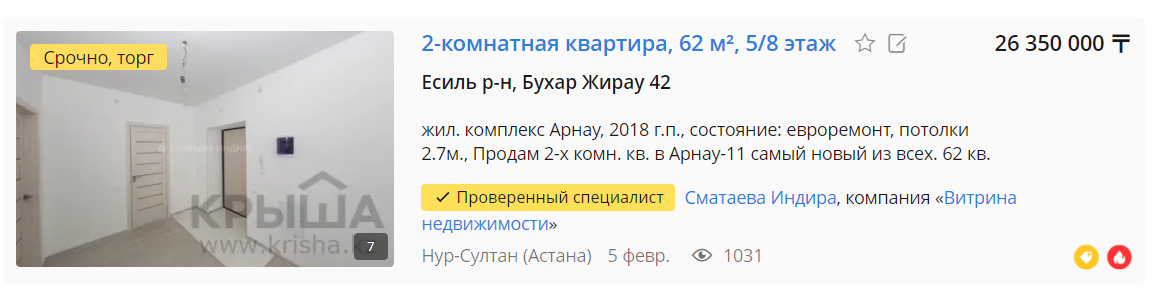

Number_of_rooms = 2.0

Area = 62.00

District_name = 2 ('Есиль')

Complex_name = 3 ('Арнау') 

Year = 2018

Condition = 2 ('евроремонт')

Storey_ratio = 3 (5/8 = 0.63 => 3)

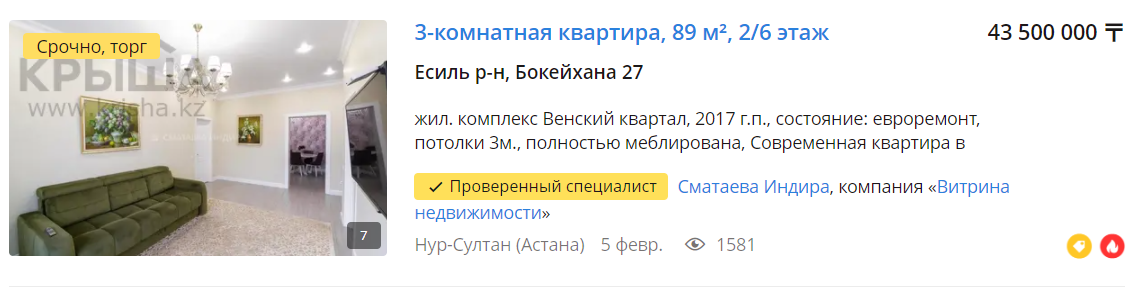

Number_of_rooms = 3.0

Area = 89.00

District_name = 2 ('Есиль')

Complex_name = 3 ('Венский квартал')

Year = 2017

Condition = 2 ('евроремонт')

Storey_ratio = 1 (2/6 = 0.33 => 1)

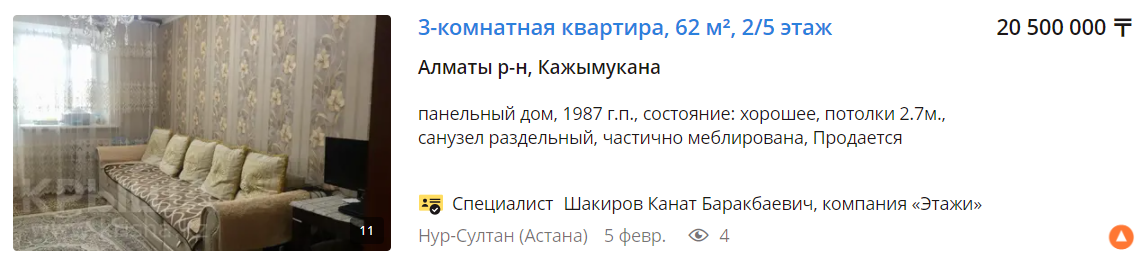

Number_of_rooms = 3.0

Area = 62.00

District_name = 1 ('Алматы')

Complex_name = 2 because average price per area = 383562.63 in the range of category 2

Year = 1987

Condition = 0 ('хорошее')

Storey_ratio = 1 (2/5 = 0.4 => 1)

In [372]:
mean_price_band_list

mean_price_band  count
0  (189137.467, 269910.712]     20
1  (269910.712, 349884.223]    200
2  (349884.223, 429857.734]    241
3  (429857.734, 509831.245]    103
4  (509831.245, 589804.756]     45
5  (589804.756, 669778.266]     19
6  (669778.266, 749751.777]      7
7  (749751.777, 829725.288]      9
8  (829725.288, 909698.799]      4
9  (909698.799, 989672.309]      1

In [373]:
x_1 = pd.DataFrame(np.array([[2.0, 62.00, 2, 3, 2018.0, 2, 3], [3.0, 89.00, 2, 3, 2017.0, 2, 3], 
                            [3.0, 62.00, 1, 2, 1987.0, 0, 1]]),
                   columns=['number_of_rooms', 'area', 'district', 'complex_name', 'year', 'condition', 'storey_ratio'])
x_1

number_of_rooms  area  district  complex_name    year  condition  \
0              2.0  62.0       2.0           3.0  2018.0        2.0   
1              3.0  89.0       2.0           3.0  2017.0        2.0   
2              3.0  62.0       1.0           2.0  1987.0        0.0   

   storey_ratio  
0           3.0  
1           3.0  
2           1.0

In [374]:
print(dec_reg.predict(x_1))
print(grad_boost.predict(x_1))
print(rand_for_reg.predict(x_1))

[29653571.42857143 40661538.46153846 23128772.75      ]
[28484528.84916782 41270999.34191836 23050216.37436256]
[29130000.  43160000.  23249999.3]


Real prices on the website are 26 350 000, 43 500 000 and 20 500 000. They are quite close to the predicted results.